# Miniproject 1 #

In [1]:
# duh
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal # For signal generation + convolution
from scipy.stats import gamma # For Gamma function
from random import sample # just for a demo

## 1. Generation of the Stimulus Signal ##

We imaging to show the stimuli to the subject as described in the assignment paper. Assume a linear activation of neurons with the presentation oft he stimuli, thus, the signal created below is assumed to correspond to the actual activation of the neurons. 

*Should we consider controls?*

*"Each individual presentation lasting 2 seconds": does that mean Diracs 2 seconds apart?*

/Users/matteorighi/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/waveforms.py:658: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif idx == 'mid':


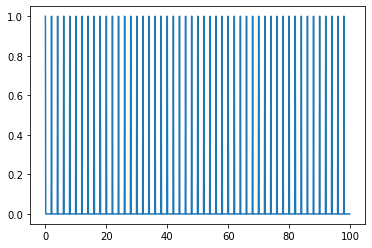

In [2]:
TR = 5 #[sec] - true recording period

Ts = 0.1 # [sec] - simulated frequency, to avoid bouncing in convolution
total_duration = 100 # [sec]
t = np.arange(0, total_duration, Ts)

isi = 2 # [sec] - presentation duration
# episode_duration = 10 # [sec] - used for square waves

neur = scipy.signal.unit_impulse(int(total_duration/Ts), np.arange(0, int(total_duration/Ts), int(isi/Ts)))

plt.plot(t, neur)

## 2. Generation of the HRF Response Function ##

We now consider the response of the blood-oxygen level (BOLD) signal.

Consider an impulse (ie Dirac impulse) activation of one neuron; as seen in class, then blood-oxygen level varies accordingly. This response of the BOLD signal forms the impulse response of the LTI system whose input is the abstracted neural activation (ie on/off) and whose output is the BOLD signal. This is called the hemoglobin (?) response function HRF. 

There is an initial phase of overcompensation or overshoot where the oxygen level is raised far above neutral level, then a second phase of undershoot where the oxygen level temporarily drops. These two phases are modelled by the shape of a gamma probability distribution. 

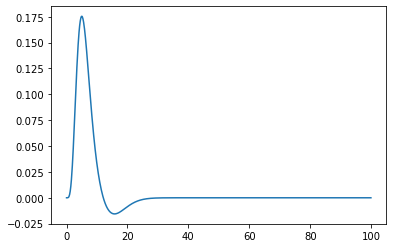

In [3]:
A = 1 # temporary (?)

alpha1 = 6
alpha2 = 16
beta1 = 1
beta2 = 1
c = 1/6

h = A*gamma.pdf(t, alpha1, scale=1/beta1)- c*gamma.pdf(t, alpha2, scale=1/beta2)

plt.plot(t, h)

Note: per the documentation for the Gamma function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html), gamma.pdf(t, a, scale=1/b) is equivalent to $\frac{b^a x^{a-1}e^{b t}}{\Gamma(a)}$

Now we can obtain the measured BOLD response by convolving the simulated neural activation signal with the HRF: (mode='same' gives an output of same size as the first argument)

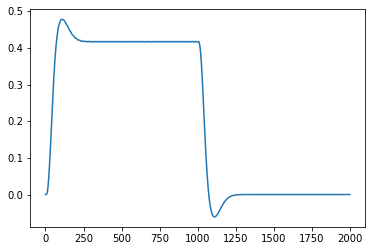

In [4]:
bold = scipy.signal.convolve(neur, h, mode='full')

plt.plot(bold)

Note that the BOLD signal is longer, and drops at the end of the measurment. For simplicity, we can crop out all parts of the signal outside of the measurement time. 

*Note that using mode="valid" on the convolution crops the output to incldue the ending*

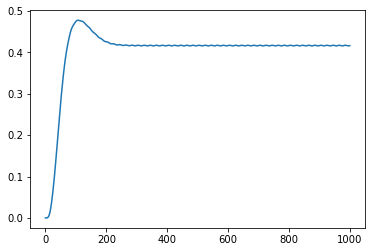

In [5]:
bold = bold[0:int(total_duration/Ts)]

plt.plot(bold)

## 3. Observing the Effects of the alpha Parameters

/var/folders/bj/jt74ftb16rjc33clq00_ylx80000gn/T/ipykernel_51093/976608538.py:7: RuntimeWarning: invalid value encountered in subtract
  axs[i,j].plot(t, gamma.pdf(t, alpha1s[i], scale=1/beta1)- c*gamma.pdf(t, alpha2s[j], scale=1/beta2))


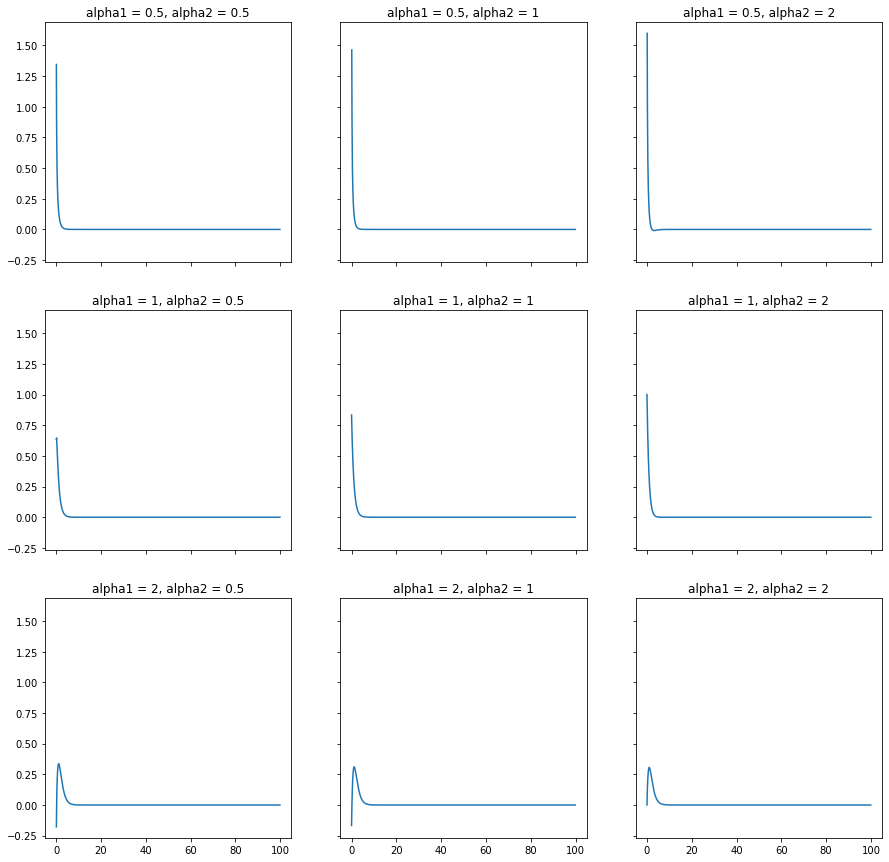

In [6]:
alpha1s = [0.5, 1, 2]*alpha1
alpha2s = [0.5, 1, 2]*alpha2

fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        axs[i,j].plot(t, gamma.pdf(t, alpha1s[i], scale=1/beta1)- c*gamma.pdf(t, alpha2s[j], scale=1/beta2))
        axs[i,j].set_title(f"alpha1 = {alpha1s[i]}, alpha2 = {alpha2s[j]}")

## 4. Adding Gaussian Noise ##

In [7]:
sigma = 0.15 # std dev of the noise added
bold_noisy = bold + np.random.normal(0, sigma, t.shape)

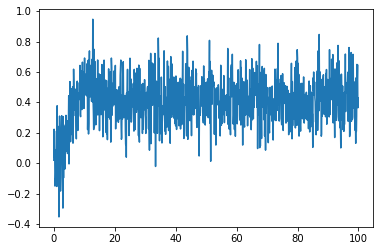

In [8]:
plt.plot(t, bold_noisy)

## 5. Construction of the GLM ##

Construct a GLM where y is the simulated BOLD voxel time-series. Then we attempt to interpolate the neuron activation from a matrix X of basis vectors. Each column corresponds to a HRF function convolved with a Dirac at the moment of a presentation. 

In [9]:
y = bold_noisy

X = np.zeros((int(total_duration/Ts), int(total_duration/isi)))
for i in range(0, X.shape[1]):
    col = scipy.signal.unit_impulse(int(total_duration/Ts), i*int(isi/Ts))
    col = scipy.signal.convolve(col, h, mode='full')
    col=col[0:t.shape[0]]
    X[:,i]=col

Graphically show a random subset of the regressors:

Random values chosen are [46, 28, 32, 37, 18]


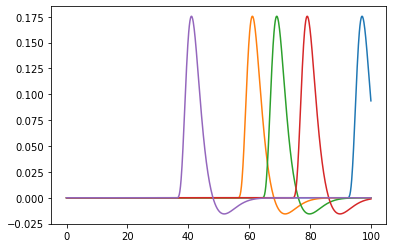

In [10]:
rand = sample(range(0, X.shape[1]), 5)
print(f"Random values chosen are {rand}")
for i in rand:
    plt.plot(t, X[:,i])

## 6. Solving the GLM ##

Using OLS estimator; using the formula as seen in class:
$$ \bar{\beta} = (X^TX)^{-1}X^Ty $$

In [11]:
beta = np.linalg.inv(X.T@X)@X.T@y
y_hat = X@beta

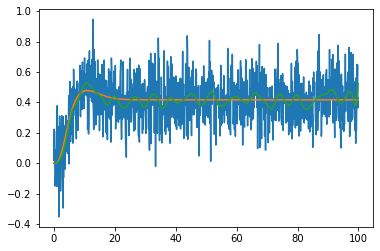

In [12]:
plt.plot(t,y)
plt.plot(t, bold)
plt.plot(t,y_hat)

In [13]:
print(np.sum(np.abs(bold-y_hat)))

25.75743578498812


*Correct to do bold and not y???*

## 7. Hypothesis Test on the Regressors ##

In [14]:
print(beta)

[ 0.63514316  1.4202309   0.43780725  1.75356076  0.68286536  0.97016696
  1.02303289  0.55976511  1.75685318  0.154514    1.20630953  1.22496801
  0.87908332  0.51926605  1.69812856  0.76886333  0.37930085  1.87650076
  0.28863551  1.30608643  1.02126738  1.23582218  0.35572719  1.42848404
  1.3577603   0.30325537  1.19157694  1.13865466  1.01425123  0.89489346
  0.84403316  1.59017806  0.54644267  1.06754894  0.5579761   1.91804634
  0.1899032   1.1432099   1.50789053  0.14467789  1.25734627  1.11214491
  1.07738013  1.05045604  1.38065892  0.23955486  1.67887621  1.13527677
 -0.31320423  9.02901551]


## 8. Graphical Representation of the Design Matrix ##

## 9. Repeat for a Real Dataset (Optional) ##